In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import warnings
warnings.filterwarnings("ignore")

os.environ["TOKENIZERS_PARALLELISM"] = "true"

In [14]:
import flwr as fl

## 🧑‍🍳 Step 1: Grab the Recipe — Load Your Training Configuration

Every great dish starts with a recipe — and in this notebook, that recipe is your config file.

In this step, we’re using Hydra to load a YAML configuration that defines all the key ingredients and settings for your federated fine-tuning experiment. Think of it as pulling out the instruction card before cooking.

📦 What this does:
- Loads a configuration file (in this case, federated_7b.yml) using Hydra.
- Prints out the full config in a readable YAML format, thanks to OmegaConf.

> Technically you can use `yaml.load()` too because we are using single, static files. Using Hydra allows us to work with more complex, hierarchical nested structures and dynamically override parts of the config from CLI or code like: `python train.py model=transformer optimizer=adam`

In [12]:
from hydra import compose, initialize
from omegaconf import DictConfig, OmegaConf

def get_config(config_name: str, config_path: str = "../config/"):
    with initialize(config_path=config_path, version_base="1.1"):
        cfg = compose(config_name=config_name)

    return cfg

def print_config(config: DictConfig):
    print(OmegaConf.to_yaml(config))

In [11]:
cfg = get_config("federated_7b.yml")

In [13]:
print_config(cfg)

dataset:
  name: medalpaca/medical_meadow_medical_flashcards
model:
  name: mistralai/Mistral-7B-v0.1
  quantization: 4
  gradient_checkpointing: true
  use_fast_tokenizer: false
  lora:
    peft_lora_r: 16
    peft_lora_alpha: 64
    target_modules:
    - q_proj
    - v_proj
train:
  num_rounds: ${flower.num_rounds}
  save_every_round: 5
  learning_rate_max: 5.0e-05
  learning_rate_min: 1.0e-06
  seq_length: 512
  padding_side: left
  evaluate_split: true
  training_arguments:
    output_dir: null
    learning_rate: null
    per_device_train_batch_size: 16
    gradient_accumulation_steps: 1
    logging_steps: 10
    num_train_epochs: 3
    max_steps: 10
    report_to: null
    save_steps: 1000
    save_total_limit: 10
    gradient_checkpointing: ${model.gradient_checkpointing}
    lr_scheduler_type: constant
client_resources:
  num_cpus: 8
  num_gpus: 1.0
dp:
  noise_mult: 0.02
  clip_norm: 0.5
flower:
  num_clients: 20
  num_rounds: 200
  fraction_fit: 0.8
  client_resources:
    num

## 👨‍🍳 Step 2: Prepare the Ingredients — Format and Partition Your Dataset

Every chef knows the importance of prepping ingredients before cooking. In this step, we’re doing exactly that — slicing and dicing our dataset, then portioning it out evenly like we’re handing out bento boxes to 20 hungry students (aka clients).

📦 What this does:
- 🔪 format_dataset: Cleans and standardizes column names so all partitions speak the same language.
- 📦 IidPartitioner: Splits the dataset evenly across clients.
- 🍱 FederatedDataset: Applies the partitioning and prepares it for training.
- 📊 visualize_partitions: (Optional) Lets us peek at how evenly data is spread.


In [16]:
from flwr_datasets import FederatedDataset
from flwr_datasets.partitioner import IidPartitioner
from datasets import load_dataset
import matplotlib.pyplot as plt

def format_dataset(dataset):
    dataset = dataset.remove_columns(['instruction'])
    dataset = dataset.rename_column("output", "response")
    dataset = dataset.rename_column("input", "instruction")
    return dataset

def visualize_partitions(fed_dataset: FederatedDataset):
    _ = fed_dataset.load_partition(0)
    num_partitions = fed_dataset.partitioners['train'].num_partitions
    
    plt.bar(range(num_partitions), [len(fed_dataset.load_partition(i)) for i in range(num_partitions)])
    plt.xticks(range(num_partitions))
    plt.xlabel("Partition ID")
    plt.ylabel("Number of examples")
    plt.title(f"IID partitioning into {num_partitions} partitions")

In [17]:
partitioner = IidPartitioner(num_partitions=cfg.flower.num_clients)
fds = FederatedDataset(
    dataset=cfg.dataset.name,
    partitioners={"train": partitioner}
)

partition_zero = fds.load_partition(0) 

format_dataset(partition_zero)

README.md:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

(…)l_meadow_wikidoc_medical_flashcards.json:   0%|          | 0.00/17.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/33955 [00:00<?, ? examples/s]

Dataset({
    features: ['instruction', 'response'],
    num_rows: 1698
})

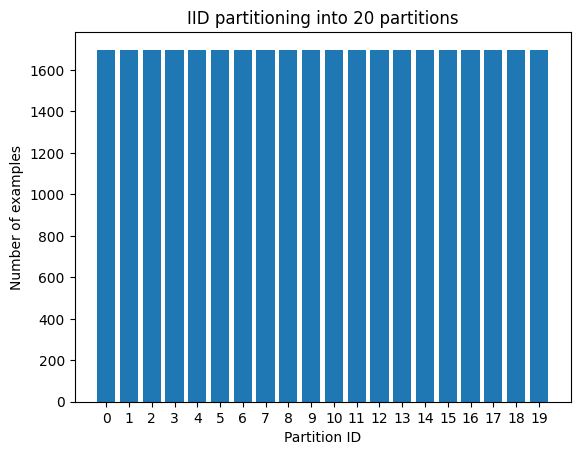

In [18]:
visualize_partitions(fds)

## 👨‍🍳 Step 3: Load the Model — Then Estimate Your Grocery Bill

Now that we’ve got our ingredients sorted and divided, it’s time to prep the kitchen. Here, we load our model, apply the right quantization, and plug in LoRA adapters to make training lighter. Then we run a quick cost check — like scanning your grocery basket before checkout.

📦 What this does:
- 🧠 Loads your pretrained model (e.g., Mistral, LLaMA).
- 💾 Applies quantization for lower memory use (4-bit/8-bit).
- 🎯 Attaches LoRA adapters — a “just train these few layers” approach.
- 🧮 Calculates communication costs for 20 simulated clients, across multiple federated rounds.

> 📈 Why this matters:
> Federated fine-tuning isn’t just about accuracy — it’s also about efficiency. Uploading 7B parameters to 20 clients for 3 rounds? The number of parameters sent by the clients to the server alone can overwhelm it. LoRA cuts that cost by 20x–100x. It's best to have a helper function to budget your bandwidth before the federated feast begins.

In [ ]:
import torch
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
)
from peft import (
    PeftModel,
    LoraConfig,
    get_peft_model,
    get_peft_model_state_dict,
    set_peft_model_state_dict,
)
from peft.utils import prepare_model_for_kbit_training
from trl import DataCollatorForCompletionOnlyLM, SFTTrainer

def get_model(model_cfg: DictConfig):
    """Load model with appropiate quantization config and
    other optimizations."""

    use_cuda = torch.cuda.is_available()
    quantization_config = None
    model_name = model_cfg.name
    if use_cuda:
        if model_cfg.quantization == 4:
            quantization_config = BitsAndBytesConfig(load_in_4bit=True)
        elif model_cfg.quantization == 8:
            quantization_config = BitsAndBytesConfig(load_in_8bit=True)
        else:
            raise ValueError(
                f"Use 4-bit or 8-bit quantization. You passed: {model_cfg.quantization}/"
            )

        model_name = model_cfg.name

    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        quantization_config=quantization_config,
        torch_dtype=torch.bfloat16,
        low_cpu_mem_usage=True,
    )

    if use_cuda:
        model = prepare_model_for_kbit_training(
            model, use_gradient_checkpointing=model_cfg.gradient_checkpointing
        )

    target_modules = model_cfg.lora.target_modules
    if target_modules:
        target_modules = list(target_modules)
    peft_config = LoraConfig(
        r=model_cfg.lora.peft_lora_r,
        lora_alpha=model_cfg.lora.peft_lora_alpha,
        lora_dropout=0.075,
        task_type="CAUSAL_LM",
        target_modules=target_modules,
    )

    peft_model = get_peft_model(model, peft_config)
    if not (use_cuda):
        peft_model.enable_input_require_grads()

    if model_cfg.gradient_checkpointing:
        model.config.use_cache = False

    return peft_model

In [21]:
def compute_communication_costs(config, comm_bw_mbps: float = 20):
    model = get_model(config.model)

    trainable, all_parameters = model.get_nb_trainable_parameters()

    total_size = 4*all_parameters/(1024**2)
    trainable_size = 4*trainable/(1024**2)

    upload_time_total = total_size/(comm_bw_mbps/8)
    upload_time_finetune = trainable_size/(comm_bw_mbps/8)
    
    print(f"Full model:\n\t{all_parameters/1e6:.3f} M parameters\n\t{total_size:.2f} MB --> upload in {upload_time_total:.2f}s @ {comm_bw_mbps}Mbps")
    print(f"Finetuned model:\n\t{trainable/1e6:.3f} M parameters\n\t{trainable_size:.2f} MB --> upload in {upload_time_finetune:.2f}s @ {comm_bw_mbps}Mbps")
    # print(f"In a {comm_bw_mbps} Mbps channel --> {}")

    num_rounds = config.flower.num_rounds
    num_clients_per_round = int(config.flower.num_clients * config.flower.fraction_fit)
    print(f"Federated Learning setting: "
          f"\n\tNumber of rounds: {num_rounds}"
          f"\n\tNumber of clients per round: {num_clients_per_round}")
    
    print(f"-----------------------------------------------")
    print(f"Total Communication costs (Full model): {2*num_rounds*num_clients_per_round*total_size/1024:.1f} GB")
    print(f"Total Communication costs (Finetuning): {2*num_rounds*num_clients_per_round*trainable_size} MB")
    print(f"Communication savings: {all_parameters/trainable:.1f}x")

In [ ]:
compute_communication_costs(cfg, comm_bw_mbps=20)

## 👨‍🍳 Step 4: Prompt Prep — Set the Table for Fine-Tuning

Before we can start cooking (i.e., training), we need to set the table properly. That means formatting the prompts, choosing the right tokenizer, and preparing a smart data collator that knows where the “response” part starts.

🧠 What’s happening here:
- 🔤 Loads the tokenizer and sets a pad token (beginning-of-sequence or end-of-sequence depending on the model).
- 📌 Finds the location in the prompt where the model should start predicting — right after "### Response:".
- 🧼 The `DataCollatorForCompletionOnlyLM` ensures that only the response gets masked for loss — so we train the model only on what it should generate.

In [ ]:
def formatting_prompts_func(example):
    output_texts = []
    # Constructing a standard Alpaca (https://github.com/tatsu-lab/stanford_alpaca#data-release) prompt
    mssg = "Below is an instruction that describes a task. Write a response that appropriately completes the request."
    for i in range(len(example["instruction"])):
        text = f"{mssg}\n### Instruction:\n{example['instruction'][i]}\n### Response: {example['response'][i]}"
        output_texts.append(text)
    return output_texts

def get_tokenizer_and_data_collator_and_prompt_formatting(
    model_name: str, use_fast: bool, padding_side: str
):

    # From: https://huggingface.co/docs/trl/en/sft_trainer
    tokenizer = AutoTokenizer.from_pretrained(
        model_name, use_fast=use_fast, padding_side=padding_side
    )

    tokenizer.pad_token = (
        tokenizer.bos_token if padding_side == "left" else tokenizer.eos_token
    )
    response_template_with_context = "\n### Response:"  # alpaca response tag
    response_template_ids = tokenizer.encode(
        response_template_with_context, add_special_tokens=False
    )[2:]
    data_collator = DataCollatorForCompletionOnlyLM(
        response_template_ids, tokenizer=tokenizer
    )

    return tokenizer, data_collator, formatting_prompts_func

In [ ]:
tokenizer, data_collator, formatting_prompts_func = get_tokenizer_and_data_collator_and_prompt_formatting(
    cfg.model.name, 
    cfg.model.use_fast_tokenizer,
    cfg.train.padding_side,
)

## 🍳 Step 5: Crafting the Flower Client – The Heartbeat of Federated Learning

In the realm of federated learning, the client is not just a participant; it’s the linchpin that holds the decentralized training process together. Think of it as a dedicated chef in a distributed kitchen, each working with their unique ingredients (data) but following a shared recipe (model architecture).

🧠 Understanding the Client’s Role

In Flower’s architecture, each client is responsible for:
1.	Receiving the Global Model: The server sends the current global model parameters to the client.
2.	Local Training: The client trains the model on its local dataset, ensuring data privacy and compliance with data governance policies.
3.	Sending Updates: After training, the client sends the updated model parameters back to the server for aggregation.

This process allows for collaborative model training without the need to centralize sensitive data.

Here's our utility function to adjust our learning rate!

In [ ]:
import math

def cosine_annealing(
    current_round: int,
    total_round: int,
    lrate_max: float = 0.001,
    lrate_min: float = 0.0,
) -> float:
    """Implement cosine annealing learning rate schedule."""

    cos_inner = math.pi * current_round / total_round
    return lrate_min + 0.5 * (lrate_max - lrate_min) * (1 + math.cos(cos_inner))


🛠️ Implementing the Flower Client

Let’s delve into the implementation:

In [ ]:
from flwr.common import Context
from flwr.common.typing import NDArrays, Scalar
from fl.client import NumPyClient

from typing import Dict, Tuple, Callable
from collections import OrderedDict

def set_parameters(model, parameters: NDArrays) -> None:
    """Change the parameters of the model using the given ones."""
    peft_state_dict_keys = get_peft_model_state_dict(model).keys()
    params_dict = zip(peft_state_dict_keys, parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    set_peft_model_state_dict(model, state_dict)

class FlowerClient(NumPyClient): 
    def __init__(
        self,
        model_cfg: DictConfig,
        train_cfg: DictConfig,
        trainset,
        tokenizer,
        formatting_prompts_func,
        data_collator,
        save_path,
    ):  
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.train_cfg = train_cfg
        self.training_argumnets = TrainingArguments(**train_cfg.training_arguments)
        self.tokenizer = tokenizer
        self.formatting_prompts_func = formatting_prompts_func
        self.data_collator = data_collator
        self.save_path = save_path

        # instantiate model
        self.model = get_model(model_cfg)

        self.trainset = trainset

    def get_parameters(self, config: Dict[str, Scalar]) -> NDArrays:
        """Return the parameters of the current net."""

        state_dict = get_peft_model_state_dict(self.model)
        return [val.cpu().numpy() for _, val in state_dict.items()]

    def fit(
        self, parameters: NDArrays, config: Dict[str, Scalar]
    ) -> Tuple[NDArrays, int, Dict]:
        """Implement distributed fit function for a given client."""
        set_parameters(self.model, parameters)

        new_lr = cosine_annealing(
            int(config["current_round"]),
            self.train_cfg.num_rounds,
            self.train_cfg.learning_rate_max,
            self.train_cfg.learning_rate_min,
        )

        self.training_argumnets.learning_rate = new_lr
        self.training_argumnets.output_dir = self.save_path

        evalset = None
        if self.train_cfg.evaluate_split:
            train_test = self.trainset.train_test_split(test_size=0.1, seed=1234)
            trainset = train_test['train']
            evalset = train_test['test']
        else:
            trainset = self.trainset

        trainer = SFTTrainer(
            model=self.model,
            tokenizer=self.tokenizer,
            args=self.training_argumnets,
            max_seq_length=self.train_cfg.seq_length,
            train_dataset=trainset,
            eval_dataset=evalset,
            formatting_func=self.formatting_prompts_func,
            data_collator=self.data_collator,
        )

        metrics = {}
        if self.train_cfg.evaluate_split:
            eval_res = trainer.evaluate()
            metrics['eval_loss'] = eval_res['eval_loss']
            print(eval_res)

        # Do local training
        results = trainer.train()

        metrics = {**metrics, "train_loss": results.training_loss}

        return (
            self.get_parameters({}),
            len(self.trainset),
            metrics,
        )

def gen_client_fn(
    fds,
    tokenizer,
    formatting_prompts_func,
    data_collator,
    model_cfg: DictConfig,
    train_cfg: DictConfig,
    save_path: str,
) -> Callable[[str], FlowerClient]:  
    """Generate the client function that creates the Flower Clients."""

    def client_fn(context: Context) -> FlowerClient:
        """Create a Flower client representing a single organization."""

        # Let's get the partition corresponding to the i-th client
        partition_id = int(context.node_config["partition-id"])
        client_trainset = fds.load_partition(partition_id, "train")
        client_trainset = client_trainset.remove_columns(["instruction"])
        client_trainset = client_trainset.rename_column("input", "instruction")
        client_trainset = client_trainset.rename_column("output", "response")
        return FlowerClient(
            model_cfg,
            train_cfg,
            client_trainset,
            tokenizer,
            formatting_prompts_func,
            data_collator,
            save_path,
        ).to_client()

    return client_fn


In [ ]:
from flwr.client.mod import fixedclipping_mod

save_path = "./my_fl_model"
client = fl.client.ClientApp(
    client_fn=gen_client_fn(
        fds,
        tokenizer,
        formatting_prompts_func,
        data_collator,
        cfg.model, 
        cfg.train, 
        save_path,
    ),
    mods=[fixedclipping_mod] 
)

🔍 Key Components Explained
- `set_parameters`: Updates the model’s parameters with those received from the server.
- `FlowerClient` Class: Inherits from NumPyClient and implements the core methods:
- `get_parameters`: Retrieves the current model parameters.
- `fit`: Trains the model on local data and returns the updated parameters along with training metrics.
- `gen_client_fn`: Generates a function to create `FlowerClient` instances, each corresponding to a unique data partition.


### 🌐 The Bigger Picture

In Flower’s architecture, the client plays a pivotal role in the federated learning process. 

By handling local training and maintaining data privacy, clients enable the collaborative development of robust models without the need for centralized data storage. This approach is especially beneficial in scenarios where data is sensitive or distributed across various locations.

For a deeper dive into Flower’s architecture and the role of clients, you can refer to the [Flower Architecture Documentation](https://flower.ai/docs/framework/explanation-flower-architecture.html).

## 🧠 Step 6: Configuring the Federated Server – Directing the Symphony 🎻

While each client trains locally, the server acts as the conductor of the federated learning orchestra. It defines how rounds are configured, how model updates are aggregated, and when models are saved.

This cell introduces three essential server-side functions:


In [ ]:
from flwr.common import Context

def get_on_fit_config():
    """
    •	Purpose: This function provides the configuration dictionary sent to each 
    client before training begins in a given round.
	•	Use Case: Clients can adapt behaviors (e.g., learning rate schedules) based
    on the current round number.
	•	Design Pattern: Returns a function (fit_config_fn) that Flower calls at each
    round.

    🧠 Analogy: This is like giving each chef a new cooking instruction every day 
    based on how many days the kitchen has been operating.
    
    """
    def fit_config_fn(server_round: int):
        fit_config = {"current_round": server_round}
        return fit_config

    return fit_config_fn

def fit_weighted_average(metrics):
    """
    •	Purpose: Calculates a weighted average of training loss across all clients.
    •	Mechanism:
        •	Each client’s training loss is scaled by the number of examples it used.
        •	This ensures larger datasets have more influence on the final average.
    •	Why It Matters: Without weighting, small datasets could skew the overall metric.
    
    Example:
    # Client 1: 100 examples, loss = 0.5 → 100 * 0.5 = 50
    # Client 2: 200 examples, loss = 0.25 → 200 * 0.25 = 50
    # Weighted average = (50 + 50) / (100 + 200) = 0.333
    """
    # Multiply accuracy of each client by number of examples used
    losses = [num_examples * m["train_loss"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"train_loss": sum(losses) / sum(examples)}

def get_evaluate_fn(model_cfg, save_every_round, total_round, save_path):
    """
    •	Purpose: Save the global model periodically during training.
	•	Conditions:
	•	Skip round 0.
	•	Save if it’s the final round or every n rounds (save_every_round).
	•	How:
	•	Reconstruct the model from the config.
	•	Load the current global parameters.
	•	Save using the HuggingFace save_pretrained method.

    🧠 Why This Matters: In federated learning, there’s no single centralized 
    training process. If something goes wrong, saved checkpoints are your recovery 
    point.

    🔁 Return Format: Always returns 0.0, {} because evaluation is optional here 
    — the function is used mainly for checkpointing.
    """

    def evaluate(server_round: int, parameters, config):
        # Save model
        if server_round != 0 and (
            server_round == total_round or server_round % save_every_round == 0
        ):
            # Init model
            model = get_model(model_cfg)
            set_parameters(model, parameters)

            model.save_pretrained(f"{save_path}/peft_{server_round}")

        return 0.0, {}

    return evaluate

🧩 How It All Fits Together

These functions collectively help manage the federated learning lifecycle:
- Configure each round (get_on_fit_config)
- Aggregate client metrics meaningfully (fit_weighted_average)
- Persist model state safely (get_evaluate_fn)

🛠️ Next Step: These will be passed into the start_server call when you launch the federated training loop.

### Building the Federated Server – Strategy with Differential Privacy 🛡️

In this final piece of the federated puzzle, you define the federated learning strategy, optionally enhance it with differential privacy, and configure the server using Flower’s ServerAppComponents.

Let’s break this down carefully.

In [ ]:
from flwr.server.strategy import (
    DifferentialPrivacyClientSideFixedClipping
)

def server_fn(context: Context):
    """
    This function returns a configured Flower server app, which will be passed to 
    start_simulation() later. It defines:
	•	The strategy for aggregation (FedAvg)
	•	How rounds behave (e.g., which clients to sample)
	•	Optional advanced features like Differential Privacy
    """

    # Define the Strategy
    ## 🔁 FedAvg is the classic federated strategy where model updates are averaged
    ## across clients.
    strategy = fl.server.strategy.FedAvg(
        min_available_clients=cfg.flower.num_clients, # total clients
        fraction_fit=cfg.flower.fraction_fit, # ratio of clients to sample
        fraction_evaluate=0.0, # No federated evaluation
        # A (optional) function used to configure a "fit()" round
        on_fit_config_fn=get_on_fit_config(),
        # A (optional) function to aggregate metrics sent by clients
        fit_metrics_aggregation_fn=fit_weighted_average,
        # A (optional) function to execute on the server after each round. 
        # In this example the function only saves the global model.
        evaluate_fn=get_evaluate_fn( 
            cfg.model,
            cfg.train.save_every_round,
            cfg.flower.num_rounds,
            save_path
        ),
    )

    # Add Differential Privacy
    sampled_clients = cfg.flower.num_clients*strategy.fraction_fit
    strategy = DifferentialPrivacyClientSideFixedClipping(
        strategy, 
        noise_multiplier=cfg.flower.dp.noise_mult,
        clipping_norm=cfg.flower.dp.clip_norm, 
        num_sampled_clients=sampled_clients
    )

    # Number of rounds to run the simulation
    num_rounds = cfg.flower.num_rounds
    config = fl.server.ServerConfig(num_rounds=num_rounds)
    
    return fl.server.ServerAppComponents(strategy=strategy, config=config) 

🧩 How This Fits In

You’ve now configured:
-	Clients: What model/data they use, and how they train
-	Server: How updates are collected, averaged, checkpointed, and protected
-	Strategies: What proportion of clients participate, and how often

Now we define the server app!

In [ ]:
server = fl.server.ServerApp(server_fn=server_fn)

## 🚀 Step 7: Running the Simulation — Launching Your Federated Learning System 🧠🌐

At this point, all components have been prepared. This cell actually starts the simulation — kicking off the training across simulated federated clients.

In [ ]:
from logging import ERROR

client_resources = dict(cfg.flower.client_resources)
backend_setup = {"logging_level": ERROR, "log_to_driver": False}
fl.simulation.run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=cfg.flower.num_clients,
    backend_config={
        "client_resources": client_resources,
        "init_args": backend_setup
    }
)